In [18]:
# importing dependencies
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [19]:
# get subsets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [20]:
# checking the subsets
print(X_train.shape) 
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [21]:
# flattening the subsets
X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)

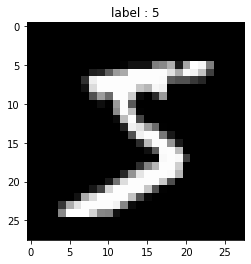

In [22]:
# visualize the data
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [23]:
# pre processing
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min())

1.0
0.0


In [24]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [25]:
# splitting our subsets into train and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [26]:
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [27]:
# mini batch
class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [28]:
# calculating the batch
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)

In [29]:
print(len(get_mini_batch))

2400


[Problem 1] Creating a code to determine the initial weight value

In [30]:
n_sample,n_features = X_train.shape
n_nodes1 = 400
sigma = 0.01 # Standard deviation of Gaussian distribution
W1 = sigma * np.random.randn(n_features, n_nodes1)

In [31]:
print(n_nodes1)

400


In [32]:
# neural network from scratch
class ScratchSimpleNeuralNetrowkClassifier():

    def __init__(self, verbose = True, n_features=784,n_nodes1=400,n_nodes2=200, batch_size=20,n_output=10, n_epoch=30, lr=0.5, sigma=0.01):
        self.verbose = verbose
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.batch_size = batch_size
        self.n_output = n_output
        self.n_epoch = 30
        self.lr = lr
        self.sigma = sigma
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        pass
    
    def fit(self, X, y, X_val=None, y_val=None):
        for epoch in range(self.n_epoch):
            get_mini_batch = GetMiniBatch(X, y, self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # forward propagation input -> hidden layer
                h = self.forward_propagation(mini_X_train, self.n_features, self.n_nodes1, 'hidden')
                # forward propagation hidden -> output layer
                o = self.forward_propagation(mini_X_train, self.n_nodes1, self.n_nodes2, 'output')
                
                
        if self.verbose:
            # When verbose is set to True, the learning process etc. is output.
            print()
        pass
    
    def create_init_w_b(self,n_feature,n_nodes, layer):
      if layer == 'hidden':
        self.W1 = self.sigma * np.random.randn(n_features, n_nodes)
        self.b1 = self.sigma * np.random.randn(n_nodes)
        return self.W1,self.b1
      else:
        self.W2 = self.sigma * np.random.randn(n_features, n_nodes)
        self.b2 = self.sigma * np.random.randn(n_nodes)
        return self.W2,self.b2
    
    def activation_function(self,X):
        return 1/(1+np.exp(-X))
    
    def forward_propagation(self,X, n_features,n_nodes, layer):
        W,b = self.create_init_w_b(n_features, n_nodes, layer)
        layer_pre = np.dot(X,W)+b
        layer = self.activation_function(layer_pre)
        return layer
        
    
    def predict(self, X):
      y_pred = []
      for image in X:
        # creating the hidden layer
        hidden_layer_pre = np.dot(image,self.W1) + self.b1
        h_layer = self.activation_function(hidden_layer_pre)

        # creating the output layer
        output_layer_pre = np.dot(image,self.W2) + self.b2
        o_layer = self.activation_function(output_layer_pre)

        y_pred.append(o_layer.argmax())
      return y_pred

In [33]:
model = ScratchSimpleNeuralNetrowkClassifier()
model.fit(X_train,y_train,X_val,y_val)

In [34]:
y_pred = model.predict(X_val)
print(y_pred)

[35, 127, 127, 182, 44, 149, 182, 34, 141, 62, 105, 46, 44, 106, 20, 193, 141, 26, 141, 192, 182, 62, 44, 39, 67, 35, 100, 67, 54, 62, 170, 35, 127, 141, 67, 34, 88, 142, 141, 62, 62, 141, 46, 20, 100, 20, 26, 62, 26, 9, 0, 44, 141, 26, 100, 20, 62, 35, 105, 193, 44, 193, 163, 142, 142, 126, 20, 46, 34, 63, 44, 20, 142, 55, 142, 141, 43, 62, 160, 23, 26, 141, 193, 44, 141, 141, 100, 88, 88, 142, 141, 100, 171, 46, 127, 35, 100, 16, 198, 54, 20, 20, 44, 142, 127, 100, 151, 99, 105, 26, 39, 67, 159, 62, 182, 141, 127, 35, 186, 0, 20, 168, 192, 19, 136, 193, 141, 193, 35, 193, 105, 105, 34, 105, 167, 105, 148, 62, 35, 62, 20, 95, 195, 141, 151, 100, 74, 141, 62, 62, 186, 34, 34, 148, 142, 193, 195, 34, 62, 111, 195, 105, 171, 44, 193, 195, 99, 48, 67, 127, 73, 141, 20, 163, 44, 168, 20, 99, 142, 148, 88, 55, 198, 97, 193, 88, 141, 193, 186, 128, 67, 142, 141, 182, 20, 105, 88, 100, 46, 141, 58, 74, 105, 141, 53, 44, 62, 105, 20, 199, 110, 67, 163, 16, 62, 23, 74, 62, 20, 100, 20, 193, 147